# Train WPD3 (WebPage Domain) detection model for phishing detection

Using new collected dataset "Phaerc_toy_dataset_v1"

## Imports

In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

In [2]:
dataset_dir = pathlib.Path("../toy_dataset/")
model_dir = pathlib.Path('../phi_models/')
checkpoint_dir = pathlib.Path('../phi_checkpoints/')

In [3]:
dataset_dirs = os.listdir(dataset_dir)
print(dataset_dirs)

['phish_images', 'trusted_images']


In [4]:
dataset_phish_dir = dataset_dirs[0]
dataset_trusted_dir = dataset_dirs[1]

In [5]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2022-09-04_19;22;59.075688


## Params

In [6]:
model_name = "wpd3"
batch_size = 16
img_height = 683 // 2
img_width = 1024 // 2

rest_split_ratio = 0.2
test_split_ratio = 0.2

## Load dataset

In [7]:
dataset_dir/dataset_trusted_dir

WindowsPath('../toy_dataset/trusted_images')

In [8]:
train_trusted_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/dataset_trusted_dir,
  validation_split=rest_split_ratio,
  subset="training",
  seed=1324,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12134 files belonging to 69 classes.
Using 9708 files for training.


In [9]:
train_trusted_ds.cardinality().numpy() * 16

9712

In [10]:
rest_trusted_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/dataset_trusted_dir,
  #label_mode = 'categorical',
  validation_split=rest_split_ratio,
  subset="validation",
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12134 files belonging to 69 classes.
Using 2426 files for validation.


In [11]:
class_names = train_trusted_ds.class_names
num_classes = len(class_names)

In [12]:
# test_phi_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   # dataset_dir/dataset_phish_dir,
#   dataset_dir/dataset_phish_dir,
#   seed=1324,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

In [13]:
# rest_phi_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   dataset_dir/dataset_phish_dir,
#   validation_split=rest_split_ratio,
#   subset="validation",
#   seed=1324,
#   image_size=(img_height, img_width),
#   batch_size=batch_size

In [14]:
# train_ds = train_trusted_ds.concatenate(train_phi_ds)
# rest_ds = rest_trusted_ds.concatenate(rest_phi_ds)
train_ds = train_trusted_ds
rest_ds = rest_trusted_ds

In [15]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

152


In [16]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio))

In [17]:
print(class_names, num_classes)

['aliexpress_com_images', 'apple_com_images', 'balady_gov_sa_images', 'citc_gov_sa_images', 'hrsd_gov_sa_images', 'loungekey_com_images', 'mewa_gov_sa_images', 'mlsd_gov_sa_images', 'moe_gov_sa_images', 'moh_gov_sa_images', 'najiz_sa_images', 'portal_ca_gov_sa_images', 'sa_iherb_com_images', 'sa_zain_com_images', 'sabq_org_images', 'store_steampowered_com_images', 'stripe_com_images', 'thmanyah_com_images', 'www_airarabia_com_images', 'www_airbnb_com_images', 'www_al-jazirah_com_images', 'www_alahli_com_images', 'www_alibaba_com_images', 'www_americanexpress_com_images', 'www_americanexpress_com_sa_images', 'www_anb_com_sa_images', 'www_aramex_com_images', 'www_argaam_com_images', 'www_att_com_images', 'www_bankaljazira_com_images', 'www_binance_com_images', 'www_coursera_com_images', 'www_dropbox_com_images', 'www_ebay_com_images', 'www_emirates_com_images', 'www_etisalat_ae_images', 'www_facebook_com_images', 'www_flyfrontier_com_images', 'www_flynas_com_images', 'www_google_com_imag

In [18]:
train_ds.cardinality().numpy()

607

In [19]:
val_ds.cardinality().numpy()

122

In [20]:
test_ds.cardinality().numpy()

30

## Visualize data

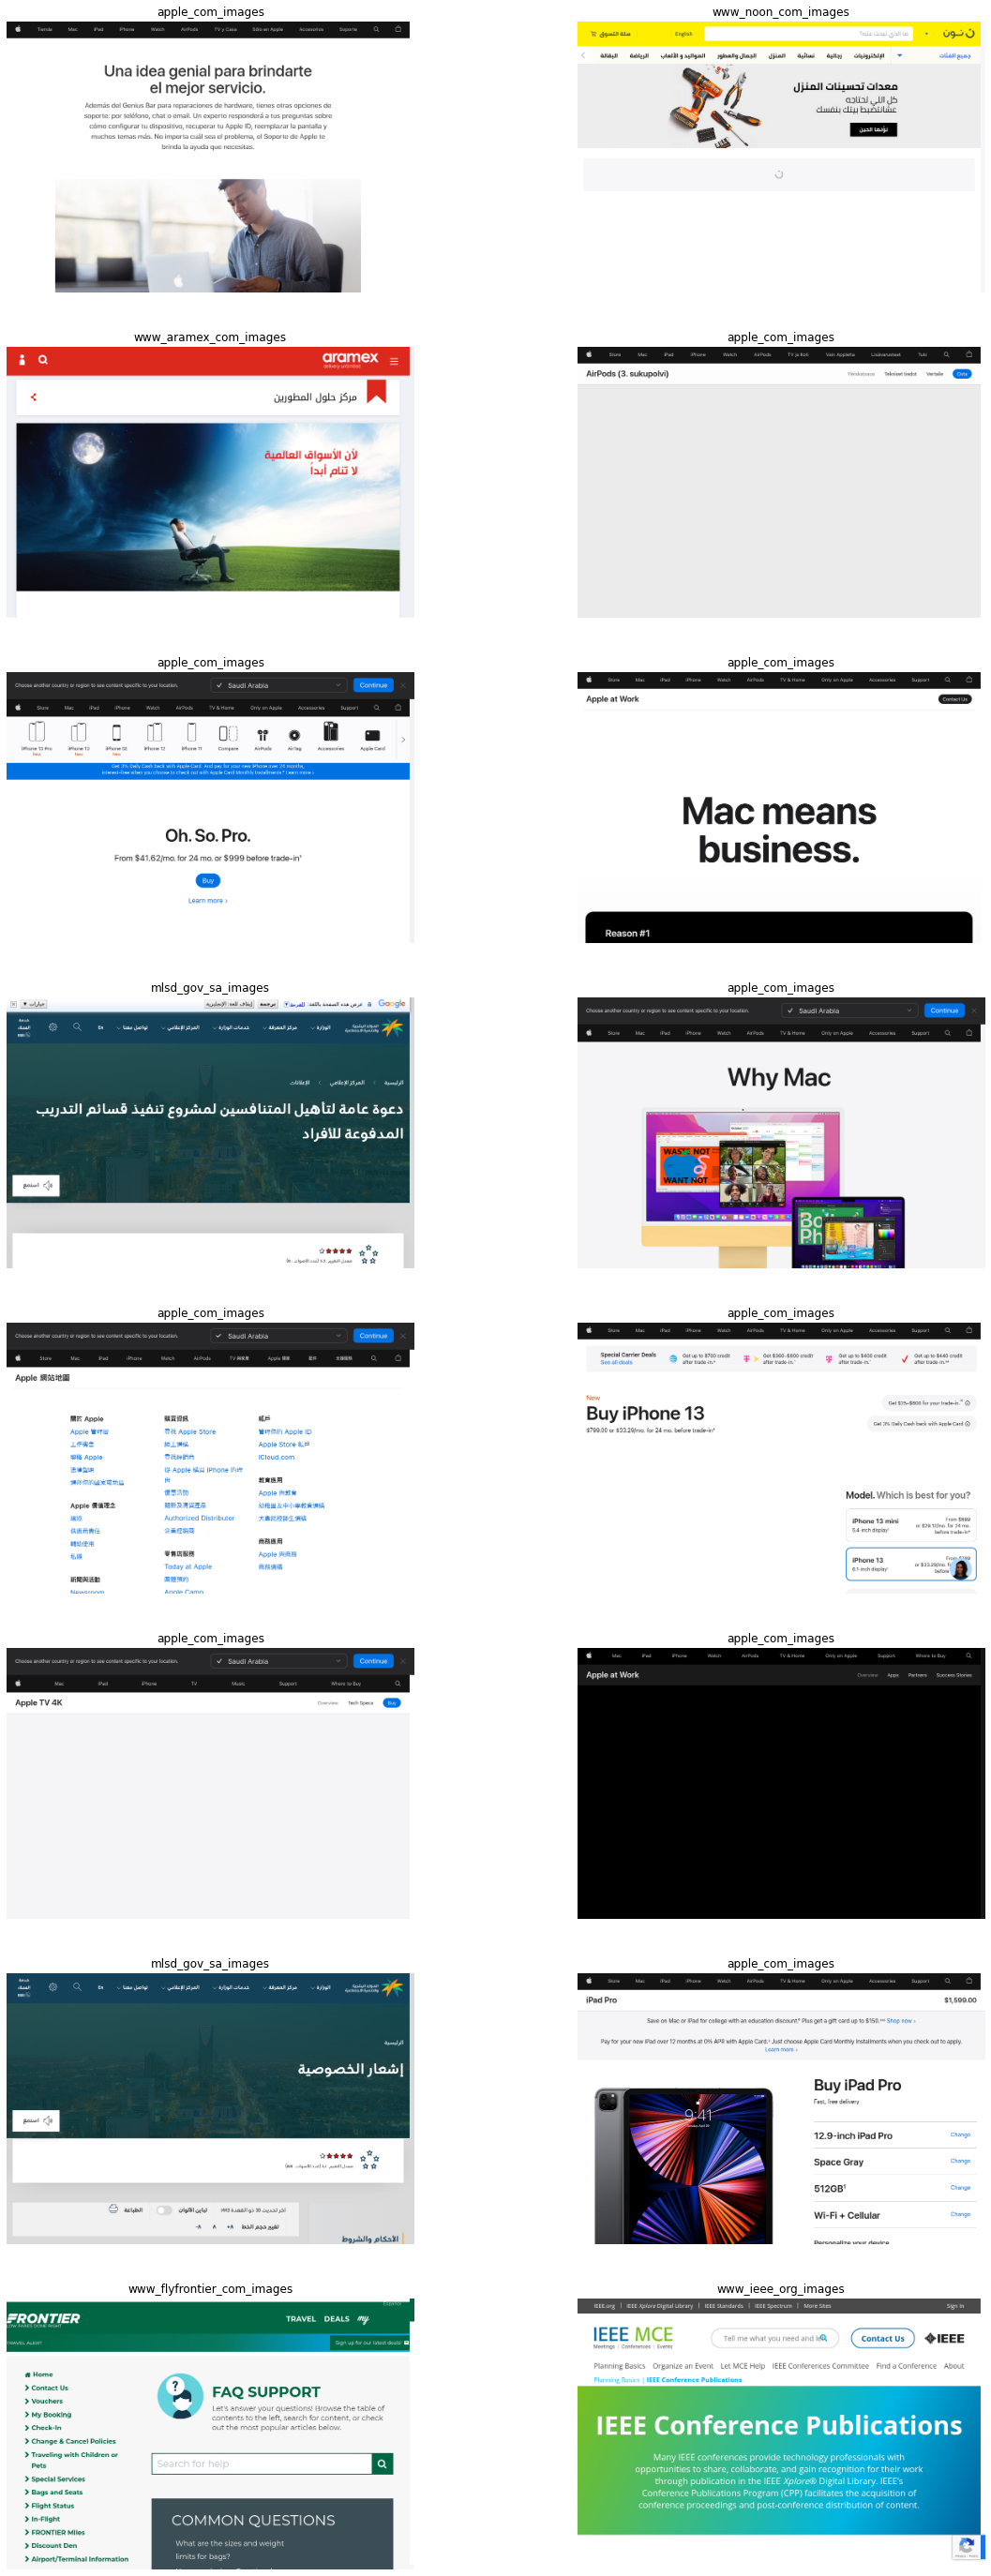

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 50))
# print([ (i,l) for i, l intrain_ds..take(1).as_numpy_iterator()])
for images, labels in train_trusted_ds.take(1):
  for i in range(16):
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Tune dataset

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
shuffle_size = 64
train_ds = train_ds.cache().shuffle(shuffle_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarize the dataset

In [23]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Model

In [24]:
#num_classes = 2
dropout_prob1 = 0.4
dropout_prob2 = 0.5
reg_rate1 = 0.005
reg_rate2 = 0.001
model = Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3),
#                 activity_regularizer=regularizers.l2(reg_rate1)
               ),
  layers.MaxPooling2D(pool_size=(4, 4), strides=(3, 3), padding='valid'),
  layers.Conv2D(16, 3, padding='same', activation='relu',
#                activity_regularizer=regularizers.l2(reg_rate1)
               ),
  layers.MaxPooling2D(pool_size=(4, 4), strides=(3, 3), padding='valid'),
  layers.Dropout(dropout_prob1),
  layers.Conv2D(16, 3, padding='valid', activation='relu',
#                activity_regularizer=regularizers.l2(reg_rate2)
               ),
  layers.MaxPooling2D(),
  layers.Dropout(dropout_prob2),
  layers.Flatten(),
  # layers.Dense(256, activation='relu',
#               activity_regularizer=regularizers.l2(reg_rate2)
              # ),
  layers.Dense(num_classes)
])


In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [26]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 341, 512, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 170, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 170, 16)      4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 56, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 54, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 27, 16)        0

## Training

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]


In [28]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/10
607/607 [==============================] - 53s 75ms/step - loss: 0.9463 - accuracy: 0.8010 - val_loss: 0.2647 - val_accuracy: 0.9491

Epoch 00001: val_loss improved from inf to 0.26473, saving model to ..\phi_checkpoints\2022-09-04_19;22;59.075688_wpd3_valacc0.9491_e1
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2022-09-04_19;22;59.075688_wpd3_valacc0.9491_e1\assets
Epoch 2/10
607/607 [==============================] - 37s 61ms/step - loss: 0.2494 - accuracy: 0.9413 - val_loss: 0.1236 - val_accuracy: 0.9723

Epoch 00002: val_loss improved from 0.26473 to 0.12364, saving model to ..\phi_checkpoints\2022-09-04_19;22;59.075688_wpd3_valacc0.9723_e2
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2022-09-04_19;22;59.075688_wpd3_valacc0.9723_e2\assets
Epoch 3/10
607/607 [==============================] - 34s 56ms/step - loss: 0.1483 - accuracy: 0.9626 - val_loss: 0.0995 - val_accuracy: 0.9820

Epoch 00003: val_loss improved from 0.12364 to 0.09952, saving model to .

## Save model

In [29]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: ..\phi_models\2022-09-04_19;22;59.075688_wpd3_valacc0.9836_e10_b16.tf\assets


## Load best model

In [34]:
# change filename to the model you want to load
model_filename = "2022-09-04_19;22;59.075688_wpd3_valacc0.9856_e8"
# model2 = keras.models.load_model(
#     model_dir / model_filename,
#     compile=True)
model2 = keras.models.load_model(
    checkpoint_dir / model_filename,
    compile=True)

## Visulaize loss and acc

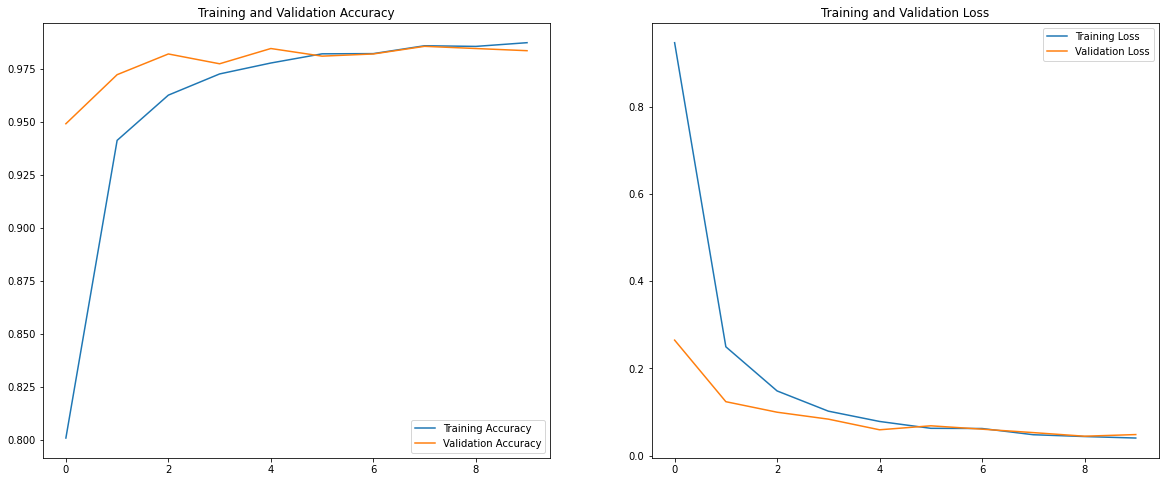

In [31]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [32]:
val_results = model.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

122/122 [==============================] - 3s 20ms/step - loss: 0.0483 - accuracy: 0.9836
val loss, val acc: [0.04829421639442444, 0.9835560321807861]


In [33]:
results = model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


30/30 [==============================] - 2s 47ms/step - loss: 0.0585 - accuracy: 0.9854
test loss, test acc: [0.058494143187999725, 0.9854166507720947]


In [35]:
val2_results = model2.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val2_results)

122/122 [==============================] - 3s 19ms/step - loss: 0.0528 - accuracy: 0.9856
val loss, val acc: [0.052794620394706726, 0.9856114983558655]


In [36]:
results2 = model2.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results2)


30/30 [==============================] - 1s 19ms/step - loss: 0.0444 - accuracy: 0.9896
test loss, test acc: [0.044419944286346436, 0.9895833134651184]
